In [2]:
import torch.nn as nn
import numpy as np
import gym
from seagul.rl.ars.meta_ars import MetaARSAgent
import matplotlib.pyplot as plt
import torch
import dill
import seagul.envs
import pybullet_envs
import pickle
from scipy.signal import find_peaks

from common import *

/home/sgillen/work/seagul/seagul/envs/__init__.py:56: UserWarning: Warning, pybullet envs not installed
  warnings.warn("Warning, pybullet envs not installed")


In [3]:
meta_agent = pickle.load(open("meta_hmap_hopper_obs", "rb"))
agent0 = meta_agent.agents[4]

In [8]:
env_name = "hmap_hopper-v0"
seed = 4
env = gym.make(env_name,slope=0)
#env = gym.make("Hopper-v2")

#agent = meta_agent.agents[seed]
obs, act, rew, _ = do_rollout(env, agent0.model, render=False, ep_length=1000)
print(sum(rew))

[2793.95530853]


In [9]:
agent0.env_config={"slope":0}
agent0.postprocessor = mdim_div
agent0.learn(100);

0 : mean return: 2257.0066604988187, fps:34316.626699265675
10 : mean return: 2346.026259695692, fps:34619.167922577486
20 : mean return: 2246.0832021957535, fps:33516.50335229774
30 : mean return: 2478.2639874797187, fps:33366.62129371324
40 : mean return: 2412.1077270989954, fps:32807.84773462942
50 : mean return: 2542.4668712581497, fps:34130.4545430806
60 : mean return: 2468.312736382441, fps:32453.402795217386
70 : mean return: 2350.0852841359338, fps:33946.899447889504
80 : mean return: 2513.708432978126, fps:33187.376972776605
90 : mean return: 2371.826097819441, fps:33500.69765448085


In [ ]:
import copy
agent_list = []
slope_set = [-.01, 0, .01]
for slope in slope_set:
    agent = copy.deepcopy(agent0)
    agent.postprocessor = mdim_div
    agent.env_config = {"slope":slope}
    agent.learn(200)
    agent_list.append(agent)

0 : mean return: 380.07388267637987, fps:36473.22986609674
10 : mean return: 679.8741076824333, fps:20949.795750903242
20 : mean return: 1421.5226652353701, fps:24395.46698394555
30 : mean return: 1578.95431600567, fps:24951.09262568092
40 : mean return: 1627.7769633218973, fps:25668.382962369225
50 : mean return: 1748.7127069501682, fps:25680.559051393633
60 : mean return: 1940.7334806700123, fps:26253.32246093548
70 : mean return: 1959.2201672023157, fps:24820.89109741163
80 : mean return: 1927.429324347901, fps:26921.123592809323
90 : mean return: 1898.550504537452, fps:26709.166027013463
100 : mean return: 1951.8213088246132, fps:26660.395204551318
110 : mean return: 1912.7742544210053, fps:26681.4292831005
120 : mean return: 1954.5380219624114, fps:26544.894303173853
130 : mean return: 1840.2582526910037, fps:25667.241134270153


In [12]:
import xarray as xr

n_runs = 5
data = xr.DataArray(np.zeros((len(slope_set), len(agent_list), n_runs)),
                    dims=("slope", "agent", "run"))

for i, slope in enumerate(slope_set):
    env = gym.make(env_name, slope=slope)
    for j, agent in enumerate(agent_list):
        for run in range(n_runs):
            obs,act,rew,_ = do_rollout(env, agent.model)
            data.loc[i, j, run] = sum(rew).item()
            

In [7]:
data.mean(dim='run')

<xarray.DataArray (slope: 3, agent: 3)>
array([[1514.6400494 , 1403.79759553, -343.67235674],
       [2840.46439883, 3182.7448662 , 1756.20082211],
       [1894.50751372, 1620.70813225, 2217.01471285]])
Dimensions without coordinates: slope, agent

False
11 poincare snapshots, 12 states in mesh
False
11 poincare snapshots, 23 states in mesh
True
5 poincare snapshots, 28 states in mesh


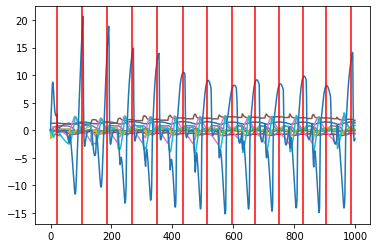

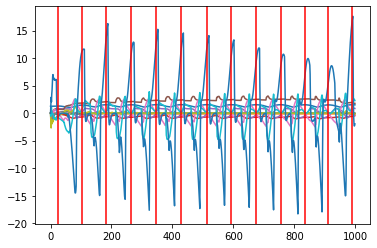

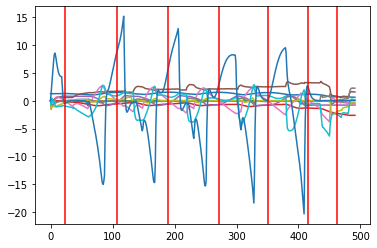

<Figure size 432x288 with 0 Axes>

In [8]:
#normal_seed  = 6
#noise_seed = 0 or 8

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    #tilted = np.abs(ob[:,1]) > .2 
    short = ob[:,0] < .7
    #return np.logical_or(tilted, short)
    return short

from common import *
from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq):
        self.state = state
        self.id = iden
        self.freq = freq
        
        self.succ_list = []
        self.pred_list = []
            
        self.ttl = 0
        self.opt_controller = None

delta = .1;
#pols = #policy_dict[post_names[1]][0:3]
pols = [agent.model for agent in agent_list]
npol = pols[0]


mesh = BoxMesh(delta); mdim_l = []


fail_state = np.ones_like(env.reset())*100
fail_id = 0
mesh[fail_state] = MeshBox(fail_state, iden = 0, freq = 1)

env = gym.make("hmap_hopper-v0", slope=0)

for policy in pols:
    obs, acts, rews, uc_obs = do_rollout(env, policy, ep_length=1000, return_on_done=True)
    peak_idx,_ = find_peaks(uc_obs[:,0], distance=20)


    for o in uc_obs[peak_idx[2:],:]:
        key = (o - npol.state_mean)/npol.state_std

        if key in mesh:
            mesh[key].freq +=1
        else:
            mesh[key] =  MeshBox(o, iden = len(mesh), freq = 1)


    plt.plot(uc_obs);
    peak_idx,_ = find_peaks(uc_obs[:,0], distance=20)

    for i in peak_idx:
        plt.axvline(x=i, color='r')

    print(fail_cond(obs).any())

    print(f"{len(peak_idx[2:])} poincare snapshots, {len(mesh)} states in mesh")
    plt.figure();

In [9]:
from multiprocessing import Pool
from itertools import repeat

def do_explore_rollout(args):
    policy, init_state, trial_num = args
    force = np.zeros(2)
    env.seed(trial_num)
    np.random.seed(trial_num)
    env.seed(trial_num)
    obs, acts, rews, uc_obs = do_push_rollout_from_state(env, policy, init_state, force)    
    
    return np.asarray(uc_obs)

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=100, force_steps = 1, render=False):
    act_list = []
    obs_list = []
    rew_list = []
    uc_obs_list = []

    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs_list.append(np.copy(obs))

        
        uc_obs_list.append(np.concatenate(
            [env.sim.data.qpos.flat[1:],
             env.sim.data.qvel.flat]))
        
        #x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)

        
        act,_,_,_ = policy.step(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_uc_obs = np.stack(uc_obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    return ep_obs, ep_act, ep_rew, ep_uc_obs




start = time.time()
keys = list(mesh.keys())[1:]
i = 0 

with Pool(12, maxtasksperchild=1000) as pool:
    for init_key in keys:    
        i+=1 
        
        init_state = mesh[init_key].state
        init_id = mesh[init_key].id
        
        state_iter = repeat(init_state, len(pols))
        rollout_seed_iter = range(i*len(pols), i*len(pols)+len(pols))

        for j, res in enumerate(pool.imap(do_explore_rollout, zip(pols, state_iter, rollout_seed_iter))):
            obs = res
    
            peak_idx,_ = find_peaks(obs[:,0], distance=20)

            if len(peak_idx) != 1 or fail_cond(obs[:peak_idx[0]]).any():
                new_id = fail_id
                new_key = fail_state
            else:
                new_key = ((obs[peak_idx,:] - np.array(npol.state_mean))/np.array(npol.state_std)).squeeze()
                if new_key in mesh:
                    new_id = mesh[new_key].id
                    mesh[new_key].freq += 1
                else:
                    mesh[new_key] = MeshBox(obs[peak_idx, :].squeeze(), len(mesh), 1)
                    new_id = len(mesh)-1
                    keys.append(mesh.__keytransform__(new_key))
            
            mesh[init_key].succ_list.append(new_id)
            mesh[new_key].pred_list.append(init_id)
                        
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

i; 1000, mdim: 1999, ratio: 0.5002501250625313
i; 2000, mdim: 3599, ratio: 0.5557099194220617
i; 3000, mdim: 5067, ratio: 0.5920663114268798
i; 4000, mdim: 6362, ratio: 0.6287331027978623
i; 5000, mdim: 7642, ratio: 0.654278984559016
i; 6000, mdim: 8824, ratio: 0.6799637352674524
i; 7000, mdim: 10043, ratio: 0.6970028875833915
i; 8000, mdim: 11164, ratio: 0.7165890361877463
i; 9000, mdim: 12249, ratio: 0.7347538574577517
i; 10000, mdim: 13273, ratio: 0.75340917652377
i; 11000, mdim: 14283, ratio: 0.7701463278022824
i; 12000, mdim: 15279, ratio: 0.785391714117416
i; 13000, mdim: 16143, ratio: 0.8053026079415226
i; 14000, mdim: 17084, ratio: 0.8194802154062281
i; 15000, mdim: 18041, ratio: 0.8314394989191286
i; 16000, mdim: 18880, ratio: 0.847457627118644
i; 17000, mdim: 19745, ratio: 0.8609774626487718
i; 18000, mdim: 20610, ratio: 0.8733624454148472
i; 19000, mdim: 21451, ratio: 0.8857395925597874
i; 20000, mdim: 22231, ratio: 0.899644640367055
i; 21000, mdim: 22998, ratio: 0.913122880

In [10]:
print(mesh)

key = list(mesh.keys())[1]

mesh_map = {state.id:state for state in mesh.values()}

# Recursive TTL

def V(mesh_id):
    mesh_state = mesh_map[mesh_id]
    
    if mesh_state.visited:
        #print(f"{mesh_id} limit cycle detected")
        mesh_state.ttl = float('inf')
        return float('inf')
        
    if (np.asarray(mesh_state.state) == fail_state).all():
        #print(f"{mesh_id} returning 0")
        return 0
    
    elif mesh_state.ttl == 0:
        #print(f"{mesh_id} descending into {mesh_state.succ_list}")
        mesh_state.visited = True
        next_list = []
        
        for next_state_id in mesh_state.succ_list:
            V_next = V(next_state_id)
            if V_next == float('inf'):
                mesh_state.ttl = float('inf')
                mesh_state.opt_controller = len(next_list)
                return float('inf')
            else:
                next_list.append(V_next)
                
        mesh_state.ttl =  1 + max(next_list)
        mesh_state.opt_controller = next_list.index(max(next_list))

        #print(f"{mesh_id} resulting list was {next_list} , new ttl is {mesh_state.ttl}")
        return mesh_state.ttl
        
    else:
        #print(f"{mesh_id} returning ttl of {mesh_state.ttl}")
        return mesh_state.ttl
    
    
# Iterative TTL   
        
for state in mesh.values():
    state.ttl = 0
    state.visited = False
    
    
V(1)

inf

In [11]:
def do_opt_rollout_from_state(env, pols, init_state, obs_std=0, act_std=0, num_steps=1000, render=True):
    act_list = []
    obs_list = []
    rew_list = []
    uc_obs_list = []

    obs = my_reset(env, init_state)
    uc_obs = np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat])
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    pi = None

    
    out = 0
    inm = 0
    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
            
        obs_key = (uc_obs - npol.state_mean)/npol.state_std
        if not obs_key in mesh:
            out+=1
        else:
            if mesh[obs_key].opt_controller is None:
                V(mesh[obs_key].id)
            
            inm +=1
            policy = pols[mesh[obs_key].opt_controller] 
            print(f"going from pol {pi} to {mesh[obs_key].opt_controller}" )
            pi = mesh[obs_key].opt_controller

        #policy = pols[0]

        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        uc_obs = torch.tensor(np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat]))
        uc_obs_list.append(np.copy(uc_obs))
        
        act,_,_,_ = policy.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_uc_obs = np.stack(uc_obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    
    print(out, inm)
    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_uc_obs

#mesh_map = {state.id:state for state in mesh.values()}

do_opt_rollout_from_state(env, pols, mesh_map[20].state)

Creating window glfw
going from pol None to 1
going from pol 1 to 1
going from pol 1 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
going from pol 0 to 0
982 18


(array([[ 1.52004646e+00, -1.45581834e-01,  3.68904825e-03, ...,
          6.65721644e-05,  8.33176080e-02,  6.86560435e+00],
        [ 1.51935406e+00, -1.45363433e-01,  3.68799054e-03, ...,
         -2.76156669e-04,  4.13722310e-02,  7.39676879e+00],
        [ 1.51788883e+00, -1.45155908e-01,  3.68169698e-03, ...,
         -1.15382558e-03,  1.02124188e-02,  7.89493000e+00],
        ...,
        [ 1.20129107e+00, -1.12705991e-01, -6.43226209e-02, ...,
         -9.77366250e-01, -1.72153419e-01, -7.78365596e+00],
        [ 1.21784525e+00, -1.16787311e-01, -7.18329784e-02, ...,
         -8.99811567e-01,  2.58441607e-01, -8.71142069e+00],
        [ 1.23528891e+00, -1.20974434e-01, -7.86933587e-02, ...,
         -8.14986527e-01,  7.09525923e-01, -9.65845865e+00]]),
 array([[ 0.99292146, -0.02715001,  0.39874612],
        [ 0.97749172, -0.02122792,  0.37967615],
        [ 0.96302183, -0.01407198,  0.35436109],
        ...,
        [ 0.04116417,  0.24680209, -2.54493258],
        [ 0.04606743